# 고속도로 CCTV 데이터 기반 차량 인식

## 1. 경로설정 및 package 로드

In [1]:
# 경로확인
import os
HOME=os.getcwd()
print(HOME)

/home/jupyter


In [63]:
# 가끔 아래의 에러가 발생할 경우 다음 코드를 실행한다.
# 로케일 에러
# NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [4]:
# ultralytics git에서 받아오기
%cd {HOME}
!git clone https://github.com/ultralytics/ultralytics
%cd ultralytics

/home/jupyter
Cloning into 'ultralytics'...
remote: Enumerating objects: 19000, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 19000 (delta 120), reused 161 (delta 110), pack-reused 18816
Receiving objects: 100% (19000/19000), 10.27 MiB | 24.58 MiB/s, done.
Resolving deltas: 100% (13286/13286), done.
/home/jupyter/ultralytics


In [64]:
!ls -al

total 81300
drwxr-xr-x 18 jupyter jupyter     4096 Nov 24 00:45 .
drwxr-xr-x  3 root    root        4096 Nov 22 04:40 ..
-rw-r--r--  1 jupyter jupyter      926 Nov 24 00:29 .bashrc
drwxr-xr-x  7 jupyter jupyter     4096 Nov 22 05:53 .cache
drwxr-xr-x  6 jupyter jupyter     4096 Nov 23 05:50 .config
drwxr-xr-x  2 jupyter jupyter     4096 Nov 22 04:41 .docker
drwxr-xr-x  3 jupyter jupyter     4096 Nov 22 04:44 .gsutil
drwxr-xr-x  2 jupyter jupyter     4096 Nov 23 02:43 .ipynb_checkpoints
drwxr-xr-x  3 jupyter jupyter     4096 Nov 22 04:41 .ipython
drwxr-xr-x  3 jupyter jupyter     4096 Nov 22 04:44 .jupyter
drwxr-xr-x  3 jupyter jupyter     4096 Nov 22 04:42 .local
drwxr-xr-x  3 jupyter jupyter     4096 Nov 22 04:42 .npm
drwx------  3 jupyter jupyter     4096 Nov 22 04:46 .nv
-rw-------  1 jupyter jupyter      824 Nov 23 00:42 .viminfo
-rw-r--r--  1 jupyter jupyter      131 Nov 24 00:41 README.dataset.txt
-rw-r--r--  1 jupyter jupyter     1107 Nov 24 00:41 README.roboflow.txt
drwxr-xr-x 

## 2. zip 파일 압축 해제

In [13]:
%%time
import zipfile
import multiprocessing
import concurrent.futures

def unzip(file):
    with lock:
        zf.extract(file, path='/home/jupyter')

zipfilePath = '/home/jupyter/highway_yolo.zip'  
zf = zipfile.ZipFile(zipfilePath)    

m = multiprocessing.Manager()
lock = m.Lock()

with concurrent.futures.ProcessPoolExecutor(max_workers=16) as executor:
    executor.map(unzip, zf.infolist())

CPU times: user 16.3 s, sys: 4.1 s, total: 20.4 s
Wall time: 5min 48s


In [ ]:
# %%time
# import zipfile
# import multiprocessing
# import concurrent.futures

# def unzip(files):
#     with lock:
#         zf.extract(files, path=destPath)

# zipfilePath = '/home/jupyter/highway_yolo.zip'
# destPath = '/home/jupyter/datasets'

# zf = zipfile.ZipFile(zipfilePath)    
# m = multiprocessing.Manager()
# lock = m.Lock()
# ZipInfo=[]
# with concurrent.futures.ProcessPoolExecutor(max_workers=16) as executor:
#     for member in zf.infolist():
#         member.filename = member.filename.encode("utf-8")
#         #member.filename = member.filename.decode("euc-kr").encode("utf-8")
#         #print(member.filename)
#     executor.map(unzip, member)

In [61]:
# 압축 해제후 데이터 갯수 맞는지 확인
import os

testPath = '/home/jupyter/dataset/train/images'
len(os.listdir(testPath))

24401

In [7]:
%cd ultralytics

/home/jupyter/ultralytics


In [11]:
# 압축 풀 때 누락된 파일 다시 풀기
!unzip -n highway_yolo.zip

Archive:  highway_yolo.zip
  inflating: dataset/test/images/Suwon_CH03_20201011_1742_SUN_9m_RH_highway_OW5_sunny_FHD_065.png  
  inflating: dataset/test/images/Suwon_CH03_20201011_1742_SUN_9m_RH_highway_OW5_sunny_FHD_066.png  
  inflating: dataset/test/images/Suwon_CH03_20201011_1742_SUN_9m_RH_highway_OW5_sunny_FHD_067.png  
  inflating: dataset/test/images/Suwon_CH03_20201011_1742_SUN_9m_RH_highway_OW5_sunny_FHD_068.png  
  inflating: dataset/test/images/Suwon_CH03_20201011_1742_SUN_9m_RH_highway_OW5_sunny_FHD_069.png  
  inflating: dataset/test/images/Suwon_CH03_20201011_1742_SUN_9m_RH_highway_OW5_sunny_FHD_070.png  
  inflating: dataset/test/images/Suwon_CH03_20201011_1742_SUN_9m_RH_highway_OW5_sunny_FHD_071.png  
  inflating: dataset/test/images/Suwon_CH03_20201011_1742_SUN_9m_RH_highway_OW5_sunny_FHD_072.png  
  inflating: dataset/test/images/Suwon_CH03_20201011_1742_SUN_9m_RH_highway_OW5_sunny_FHD_073.png  
  inflating: dataset/test/images/Suwon_CH03_20201011_1742_SUN_9m_RH_highw

In [16]:
# %cd /home/jupyter/dataset/
# !mkdir temp

/home/jupyter/dataset


In [9]:
# dataset 경로 설정
dataPath ='/home/jupyter/dataset'

## 레이블 시각화 하기

In [26]:
import glob
import os

def glob_files(path, file_type="*"):
    search_string = os.path.join(path, file_type)
    files = glob.glob(search_string)

    # print('searching ', path)
    paths = []
    for f in files:
      if os.path.isdir(f):
        sub_paths = glob_files(f + '/')
        paths += sub_paths
      else:
        paths.append(f)

    # We sort the images in alphabetical order to match them
    #  to the annotation files
    paths.sort()

    return paths

In [ ]:
import cv2
import numpy as np

IMAGE_SIZE = 600

def load_images(path):
  files = glob_files(path, "*.png")

  # print(files)
  X_data = []
  for file in files:
    image = cv2.imread(file)
    # print(image.shape)
    # x = cv2.resize(image, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)

    X_data.append(image)
  return np.array(X_data)

X_test = load_images("/home/jupyter/dataset/train/images")

In [ ]:
WIDTH = 1920
HEIGHT = 1080

def load_labels(path):
  files = glob_files(path, "*.txt")

  Y_data = []
  for file in files:
    with open(file) as f:
      lines = f.readlines()

      boxes = []
      for line in lines:
        tokens = line.split()

        class_id = int(tokens[0])
        xc = float(tokens[1]) * WIDTH
        yc = float(tokens[2]) * HEIGHT
        width = float(tokens[3]) * WIDTH
        height = float(tokens[4]) * HEIGHT

        boxes.append(np.array([class_id, xc, yc, width, height]))
        # print(class_id, xc, yc, width, height)

      Y_data.append(np.array(boxes))
      # print(lines)
  return np.array(Y_data)

Y_test = load_labels("/content/highway/bbox_highway/train/labels")

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def create_patch_rectangle(y, color):
  # # in yolov5
  width = int(y[2])
  height = int(y[3])
  return patches.Rectangle((int(y[0] - width/2), int(y[1] - height/2)),
                           width, height,
                           edgecolor=color, fill=False)

COLORS = [(0, 255/255, 0), (255/255, 255/255, 0), (255/255, 0, 0)]

def plot_image(image, boxes, axis):
  # # print(boxes.shape)
  for box in boxes:
    # print(box)
    class_id = int(box[0])
    # print(type(class_id), class_id)
    rect = create_patch_rectangle(box[1:], COLORS[class_id])
    axis.add_patch(rect)

  plt.imshow(image)

def plot_images(X, Y, limit=10):
  fig = plt.figure(figsize=(100, 80))

  last_id = min(limit, X.shape[0])
  for id in range(last_id):
    axis = fig.add_subplot(5, 3, id + 1)
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
    plot_image(X[id], Y[id], axis)

plot_images(np.array([X_test[-1]]), np.array([Y_test[-1]]))

Output hidden; open in https://colab.research.google.com to view.

## 3. 데이터셋 경로 설정하기

In [66]:
import os
from glob import glob

trainPath = os.path.join(dataPath,'train')
validPath = os.path.join(dataPath,'val')
testPath  = os.path.join(dataPath,'test')

trainImagesPath = os.path.join(trainPath, 'images')
validImagesPath = os.path.join(validPath, 'images')
testImagesPath  = os.path.join(testPath,  'images')

trainLabelsPath = os.path.join(trainPath, 'labels')
validLabelsPath = os.path.join(validPath, 'labels')
testLabelsPath  = os.path.join(testPath,  'labels')

In [30]:
# # train/images
# os.makedirs(trainImagesPath, exist_ok=True)
# os.makedirs(validImagesPath, exist_ok=True)
# os.makedirs(testImagesPath, exist_ok=True)

# os.makedirs(trainLabelsPath, exist_ok=True)
# os.makedirs(validLabelsPath, exist_ok=True)
# os.makedirs(testLabelsPath, exist_ok=True)

In [67]:
trainImagesPath, trainLabelsPath

('/home/jupyter/dataset/train/images', '/home/jupyter/dataset/train/labels')

In [32]:
# for filename in glob(os.path.join(trainPath,'*.png')):
#     basename = os.path.basename(filename)
#     os.rename(filename, os.path.join(trainImagesPath,basename))

# for filename in glob(os.path.join(validPath,'*.png')):
#     basename = os.path.basename(filename)
#     os.rename(filename, os.path.join(validImagesPath,basename))

# for filename in glob(os.path.join(testPath,'*.png')):
#     basename = os.path.basename(filename)
#     os.rename(filename, os.path.join(testImagesPath,basename))


# for filename in glob(os.path.join(trainPath,'*.txt')):
#     basename = os.path.basename(filename)
#     os.rename(filename, os.path.join(trainLabelsPath,basename))

# for filename in glob(os.path.join(validPath,'*.txt')):
#     basename = os.path.basename(filename)
#     os.rename(filename, os.path.join(validLabelsPath,basename))

# for filename in glob(os.path.join(testPath,'*.txt')):
#     basename = os.path.basename(filename)
#     os.rename(filename, os.path.join(testLabelsPath,basename))

In [68]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
udev            103G     0  103G   0% /dev
tmpfs            21G  520K   21G   1% /run
/dev/sda1        99G   33G   62G  35% /
tmpfs           103G  4.0K  103G   1% /dev/shm
tmpfs           5.0M     0  5.0M   0% /run/lock
/dev/sda15      124M   11M  114M   9% /boot/efi
/dev/sdb         98G   41G   58G  42% /home/jupyter


In [4]:
import torch

In [70]:
!nvidia-smi

Fri Nov 24 00:46:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    33W / 300W |      3MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:00:05.0 Off |                    0 |
| N/A   

In [5]:
from IPython.display import Image, clear_output  # to display images

clear_output()
print(f"Setup complete. Using torch {torch.__version__} \
    ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 2.0.0+cu118     (Tesla V100-SXM2-16GB)


In [72]:
%cd /home/jupyter

/home/jupyter


# Train Vehicle Detection Model

In [73]:
%cd ultralytics
!ls -al

/home/jupyter/ultralytics
total 57456
drwxr-xr-x 10 jupyter jupyter     4096 Nov 22 05:19 .
drwxr-xr-x 18 jupyter jupyter     4096 Nov 24 00:46 ..
drwxr-xr-x  8 jupyter jupyter     4096 Nov 23 10:07 .git
drwxr-xr-x  4 jupyter jupyter     4096 Nov 22 04:45 .github
-rw-r--r--  1 jupyter jupyter     2295 Nov 22 04:45 .gitignore
-rw-r--r--  1 jupyter jupyter     2316 Nov 22 04:45 .pre-commit-config.yaml
-rw-r--r--  1 jupyter jupyter      612 Nov 22 04:45 CITATION.cff
-rw-r--r--  1 jupyter jupyter     5597 Nov 22 04:45 CONTRIBUTING.md
-rw-r--r--  1 jupyter jupyter    34523 Nov 22 04:45 LICENSE
-rw-r--r--  1 jupyter jupyter      200 Nov 22 04:45 MANIFEST.in
-rw-r--r--  1 jupyter jupyter    28854 Nov 22 04:45 README.md
-rw-r--r--  1 jupyter jupyter    27878 Nov 22 04:45 README.zh-CN.md
drwxr-xr-x  2 jupyter jupyter     4096 Nov 22 04:45 docker
drwxr-xr-x 14 jupyter jupyter     4096 Nov 22 04:45 docs
drwxr-xr-x  9 jupyter jupyter     4096 Nov 22 04:45 examples
-rw-r--r--  1 jupyter jupyter    

In [74]:
from IPython.core.magic import register_line_cell_magic

# yaml에 직접 쓰기를 실행하는 함수
@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [10]:
dataPath

'/home/jupyter/dataset'

In [11]:
dataYaml = os.path.join(dataPath,'data.yaml')
dataYaml

'/home/jupyter/dataset/data.yaml'

In [77]:
print(trainImagesPath)
print(validImagesPath)
print(testImagesPath)

/home/jupyter/dataset/train/images
/home/jupyter/dataset/val/images
/home/jupyter/dataset/test/images


In [78]:
%%writetemplate {dataYaml}
train: /home/jupyter/dataset/train/images
val: /home/jupyter/dataset/val/images

nc: 3
names: ['car', 'bus', 'truck']

In [79]:
!pwd

/home/jupyter/ultralytics


In [80]:
!pip install ultralytics

In [18]:
!pip install opencv-python

In [81]:
import cv2

In [82]:
!pip install numba

In [49]:
from numba import cuda

In [50]:
device = cuda.get_current_device()
device.reset()

In [45]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [46]:
torch.cuda.empty_cache()

In [89]:
!nvidia-smi

Fri Nov 24 04:35:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    33W / 300W |      3MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:00:05.0 Off |                    0 |
| N/A   

In [40]:
from ultralytics import YOLO

# Load a model
#model = YOLO('yolov8n.yaml')  # build a new model from YAML
#model = YOLO('yolov8n.pt')  # load a pretrained model (recommended for training)
model = YOLO('yolov8s.yaml').load('yolov8s.pt')  # build from YAML and transfer weights

# Train the model
results = model.train(data=dataYaml, epochs=50, imgsz=800, device=[0,1,2,3], batch=72)


                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256

*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
*****************************************


Ultralytics YOLOv8.0.215 🚀 Python-3.10.13 torch-2.0.0+cu118 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
                                                             CUDA:1 (Tesla V100-SXM2-16GB, 16151MiB)
                                                             CUDA:2 (Tesla V100-SXM2-16GB, 16151MiB)
                                                             CUDA:3 (Tesla V100-SXM2-16GB, 16151MiB)
Overriding model.yaml nc=80 with nc=3
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /home/jupyter/dataset/train/labels... 2253 images, 0 backgrounds, 0 corrupt:   9%|▉         | 2253/24597 [00:29<07:00, 53.13it/s]WARNING:torch.distributed.elastic.agent.server.api:Received 2 death signal, shutting down workers
train: Scanning /home/jupyter/dataset/train/labels... 2258 images, 0 backgrounds, 0 corrupt:   9%|▉         | 2258/24597 [00:29<04:47, 77.64it/s]
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/data/dataset.py", line 104, in get_labels
    assert cache['hash'] == get_hash(self.label_files + self.im_files)  # identical hash
AssertionError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/multiprocessing/pool.py", line 856, in next
    item = self._items.popleft()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/

KeyboardInterrupt: 

In [49]:
!pwd

/home/jupyter


In [ ]:
%cd {HOME}

!yolo task=detect mode=train model=yolov8x.pt data={HOME}/dataset/data.yaml epochs=100 device=0,1,2,3 batch=32 imgsz=800 plots=True cache=True

/home/jupyter
Ultralytics YOLOv8.0.216 🚀 Python-3.10.13 torch-2.0.0+cu118 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
                                                             CUDA:1 (Tesla V100-SXM2-16GB, 16151MiB)
                                                             CUDA:2 (Tesla V100-SXM2-16GB, 16151MiB)
                                                             CUDA:3 (Tesla V100-SXM2-16GB, 16151MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/home/jupyter/dataset/data.yaml, epochs=100, patience=50, batch=32, imgsz=800, save=True, save_period=-1, cache=True, device=(0, 1, 2, 3), workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, m

/home/jupyter


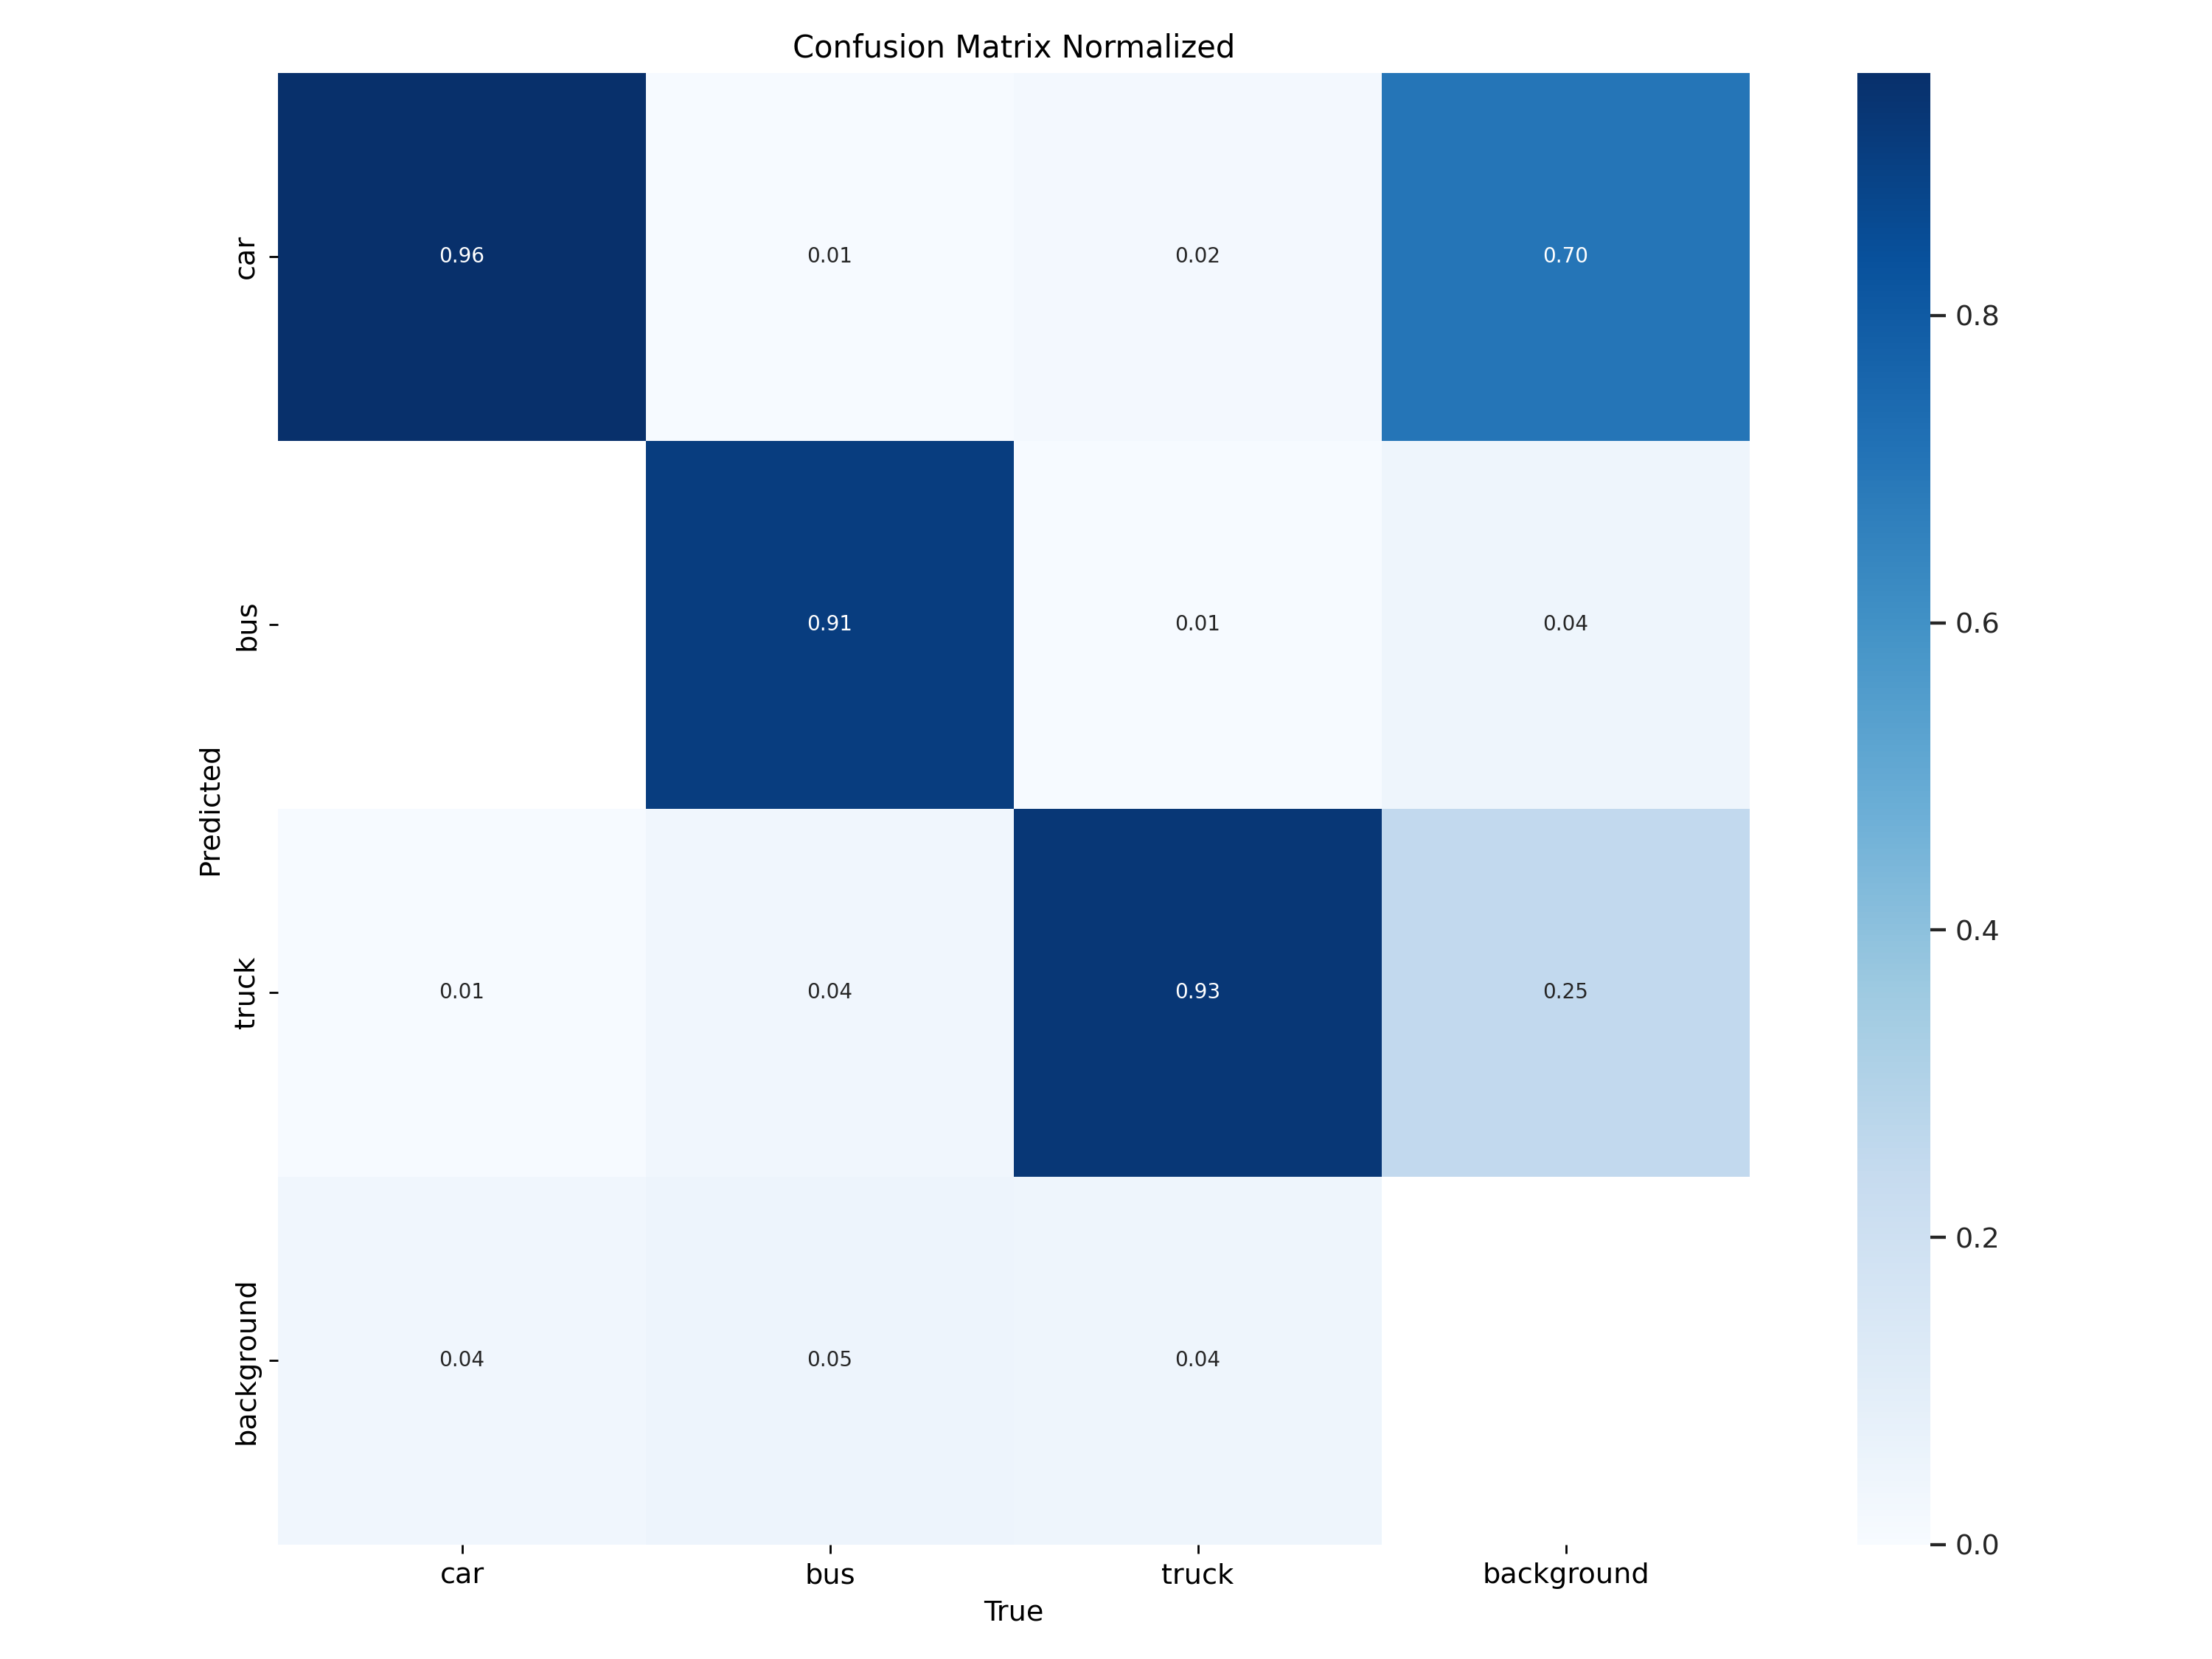

In [6]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train2/confusion_matrix_normalized.png', width=800)

In [12]:
!yolo detect val model=runs/detect/train2/weights/best.pt data={dataYaml}

Ultralytics YOLOv8.0.216 🚀 Python-3.10.13 torch-2.0.0+cu118 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
Model summary (fused): 268 layers, 68126457 parameters, 0 gradients, 257.4 GFLOPs
val: Scanning /home/jupyter/dataset/val/labels.cache... 3333 images, 103 backgro
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all       3333      49993      0.897      0.898      0.939      0.814
                   car       3333      37999      0.925      0.923      0.965      0.849
                   bus       3333       1832      0.881      0.872      0.915      0.792
                 truck       3333      10162      0.884      0.898      0.937      0.801
Speed: 0.2ms preprocess, 14.0ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val2
💡 Learn more at https://docs.ultralytics.com/modes/val


/home/jupyter


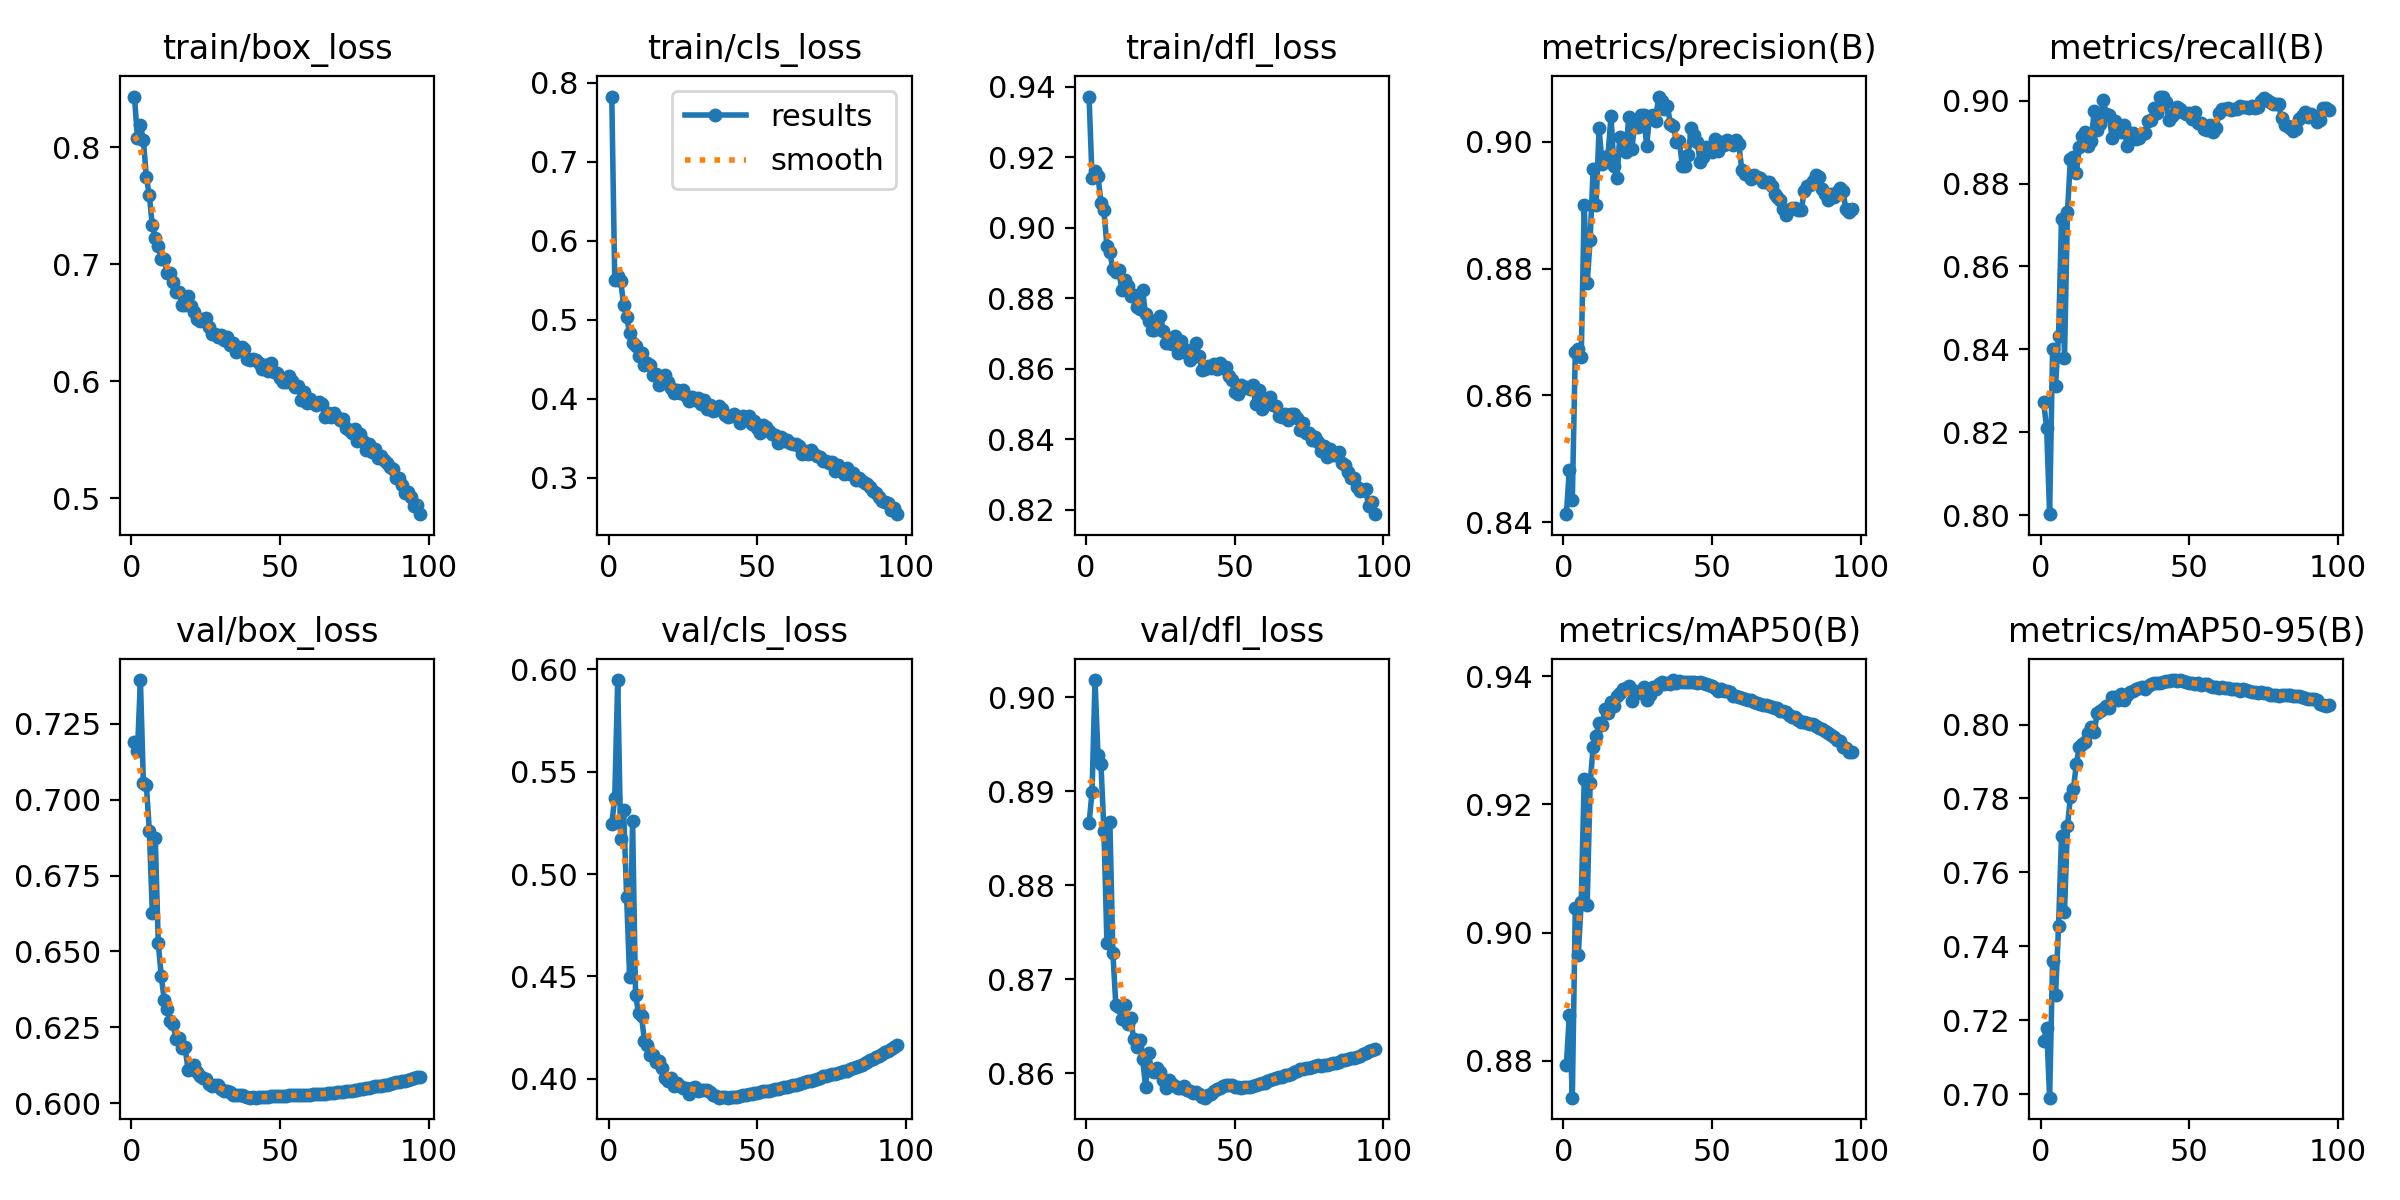

In [101]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train2/results.png', width=600)

/home/jupyter


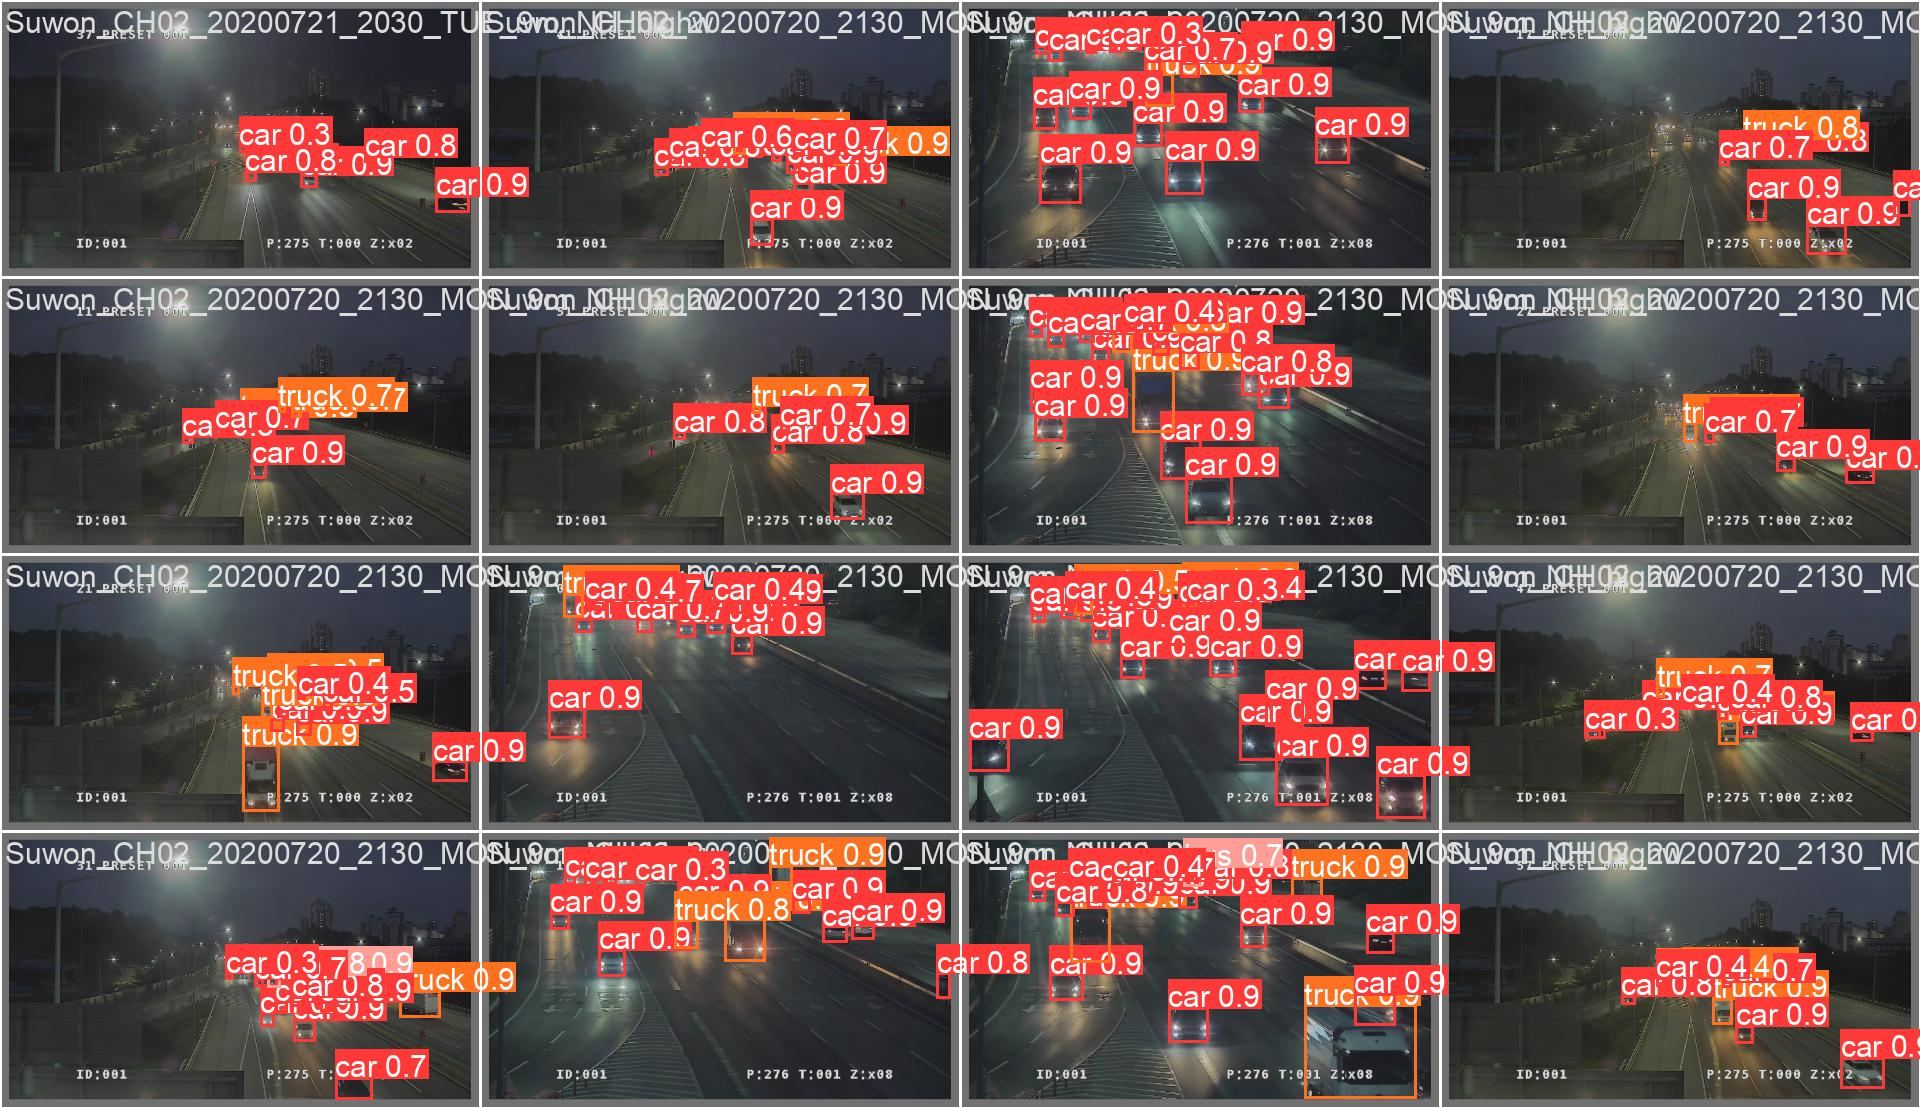

In [86]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=2000)

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8s.yaml')  # build a new model from YAML
model = YOLO('yolov8s.pt')  # load a pretrained model (recommended for training)
model = YOLO('yolov8s.yaml').load('yolov8s.pt')  # build from YAML and transfer weights

# Train the model
results = model.train(data=dataYaml, epochs=400, imgsz=640, batch=10)


                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256

In [ ]:
import os
os.getcwd()

'/content/ultralytics/ultralytics'

In [92]:
testImages = f'{HOME}/dataset/val/images'
from glob import glob

testList =[]
for filename in glob(os.path.join(testImages, '*.png')):
    testList.append(filename)

In [96]:
testList = testList[:5]
testList

['/home/jupyter/dataset/val/images/Suwon_CH01_20201012_1723_MON_9m_RH_highway_TW5_sunny_FHD_039.png',
 '/home/jupyter/dataset/val/images/Suwon_CH02_20201213_0933_SUN_9m_NH_highway_TW5_snow_FHD_009.png',
 '/home/jupyter/dataset/val/images/Suwon_CH04_20200722_1600_WED_9m_NH_highway_OW5_rainy_FHD_125.png',
 '/home/jupyter/dataset/val/images/Suwon_CH04_20200722_1600_WED_9m_NH_highway_OW5_rainy_FHD_237.png',
 '/home/jupyter/dataset/val/images/Suwon_CH04_20201010_1818_SAT_9m_RH_highway_OW5_sunny_FHD_064.png']

In [97]:
from ultralytics import YOLO

resultList =[]

# Load a pretrained YOLOv8n model
model = YOLO('/home/jupyter/runs/detect/train/weights/best.pt')

# Run inference on images
results = model(testList)

# View results
for result in results:
    resultList.append(result.cpu().numpy().boxes.cls)  # print the Boxes object containing the detection bounding boxes


0: 800x800 15 cars, 7 trucks, 1: 800x800 11 cars, 1 bus, 1 truck, 2: 800x800 11 cars, 5 trucks, 3: 800x800 6 cars, 1 bus, 1 truck, 4: 800x800 17 cars, 59.0ms
Speed: 4.3ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 800, 800)


In [98]:
import pandas as pd
sum = [0, 0, 0]

for result in resultList:
    for i in range(len(sum)):
        sum[i] += result.tolist().count(i)
print(sum)

print("전체 {}장의 이미지에서 승용차 {}대, 버스 {}대, 트럭 {}대를 발견하였습니다.".format(len(resultList), sum[0], sum[1], sum[2]))

[60, 2, 14]
전체 5장의 이미지에서 승용차 60대, 버스 2대, 트럭 14대를 발견하였습니다.


## 추가 함수들

In [56]:
%cd /content/highway/bbox_highway/
!mkdir temp

/content/highway/bbox_highway


In [71]:
def write_yolov5_txt(folder, annotation):
  out_filename = folder + annotation[0][:-3] + 'txt'
  f = open(out_filename,"w+")
  for box in annotation[3]:
    f.write("{} {} {} {} {}\n".format(box[0], box[1], box[2], box[3], box[4]))

for ann in anns:
  write_yolov5_txt(DATA_ROOT + 'train/', ann)

NameError: ignored